# Analysis

This notebook takes the data products from `wildfire.ipynb` and `aqi.ipynb` and uses those products to do analysis, create plots, and make conclusions for the final paper.

## Assumptions
1. This is a research level notebook. It is not intended to produce another data produce nor to be converted to anything for production. This is rough code and is used for creating plots and doing exploratory data analysis.
2. The `/southeast` directory with that contains `.cpg` files sits at the same level as this notebook. These files are used by the folium library to plot data onto the southeast portion of the United States for geographic distribution of fires.
3. Similarly, the `/census` directory with `.cpg` files sit at the same level
4. `wildfire.pkl` is at the same level as this notebook
5. `heart.csv` data product sits at the same level as this notebook
6. `asthma.csv` data product sits at the same level as this notebook



In [1]:
import os, json, time
from pyproj import Transformer, Geod
from wildfire.Reader import Reader as WFReader
import geojson
import pickle
import folium
import geodatasets
from geodatasets import get_path

import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# Convert shapely ring format to Lat/Lon
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [3]:
# Used to swap coordinates from Lon/Lat to Lat/Lon of the transformed data
def swap_polygon_coords(polygon):
    if polygon.is_empty:
        return polygon
    exterior_coords = [(y, x) for x, y in polygon.exterior.coords]
    swapped_polygon = Polygon(exterior_coords)
    return swapped_polygon

In [89]:
# This cell takes the data from wildfire.ipynb and turns it into a geopandas dataframe 
# by converting shapely points to (lat,lon) and then saving it to geojson

data_pickle = './wildfire.pkl'
# Open and unpickle the file
with open(data_pickle, 'rb') as file:
    fires = pickle.load(file)

print(fires[0].keys())
years = [fire['year'] for fire in fires]
names = [fire['name'] for fire in fires]
sizes = [fire['size'] for fire in fires]
types = [fire['type'] for fire in fires]
rings = [convert_ring_to_epsg4326(fire['ring']) for fire in fires]
distances = [fire['distance'] for fire in fires]

data = {'year': years,
        'distance': distances,
        'size': sizes,
        'ring': rings,
        'type': types,
        'name': names
       }

df = pd.DataFrame(data)

gdf = gpd.GeoDataFrame(df,
        geometry=[Polygon(coords) for coords in df['ring']],
        crs="EPSG:4326"
    )

# Save transformed data to geojson format
gdf.to_file("fires_final.geojson", driver="GeoJSON")

dict_keys(['year', 'name', 'size', 'type', 'ring', 'distance'])


In [4]:
# Load geo_json wildfire data
gdf = gpd.read_file('./fires_final.geojson')

In [9]:
# Do this if there are problems regarding the ring transoformation
# Might have happened to done Lon/Lat instead of Lat/Lon.

# gdf['geometry'] = gdf['geometry'].apply(swap_polygon_coords)

In [10]:
# Save the geopandas dataframe after converting to lat lon
years = gdf['year'].unique()

In [11]:
world = gpd.read_file(get_path("naturalearth.land"))

In [12]:
gdf

,year,distance,size,ring,type,name,geometry
0,1961,2343.983218,55249.740141,"[(40.368886030328014, -121.99181296130203), (4...",Wildfire,BIG ANTELOPE (5),"POLYGON ((-121.99181 40.36889, -121.99012 40.3..."
1,1961,2203.868205,43920.841077,"[(37.282516353776714, -119.69269532279587), (3...",Wildfire,HARLOW (5),"POLYGON ((-119.6927 37.28252, -119.6925 37.282..."
2,1961,2268.285607,34233.698603,"[(38.49834316287088, -120.71941227707818), (38...",Wildfire,RANCHERIA (5),"POLYGON ((-120.71941 38.49834, -120.71497 38.4..."
3,1961,2301.368232,32866.053451,"[(37.26040232218086, -121.47957213083373), (37...",Wildfire,BOLLINGER RIDGE (5),"POLYGON ((-121.47957 37.2604, -121.48207 37.25..."
4,1961,2265.726768,27269.045936,"[(45.01768500071743, -119.31593459673108), (45...",Wildfire,Ditch Creek (3),"POLYGON ((-119.31593 45.01769, -119.31549 45.0..."
...,...,...,...,...,...,...,...
118467,2020,2420.828027,16.412148,"[(43.74605950200058, -122.8914410549019), (43....",Prescribed Fire,WEW CA Broadcast (3),"POLYGON ((-122.89144 43.74606, -122.88891 43.7..."
118468,2020,2189.360048,7.050837,"[(44.00982175972205, -118.06725650490509), (44...",Prescribed Fire,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,"POLYGON ((-118.06726 44.00982, -118.07145 44.0..."
118469,2020,2189.296868,9.342668,"[(43.996724386513804, -118.07239676369375), (4...",Prescribed Fire,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,"POLYGON ((-118.0724 43.99672, -118.07195 43.99..."
118470,2020,1668.424982,0.996962,"[(40.60518870520513, -108.82139247326188), (40...",Prescribed Fire,2_WUI_Chicken Rx (1),"POLYGON ((-108.82139 40.60519, -108.82136 40.6..."


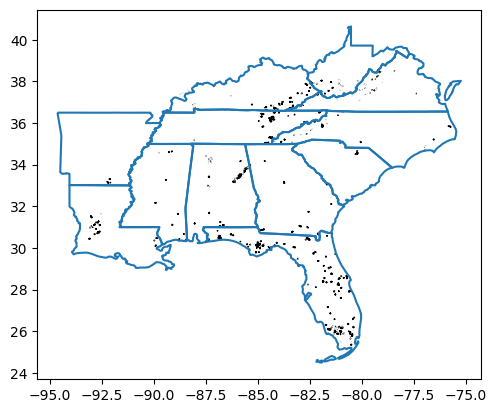

In [13]:
d = gpd.read_file('./southeast/usa-states-census-2014.shp')
southeast = d[d['region'] == 'Southeast']
ax = southeast.boundary.plot()
#ax = d[d['STUSPS']=='FL'].boundary.plot()
filter = (gdf['year']==2000) & (gdf['distance']<650)
gdf_polygons = gdf.loc[filter, 'geometry']
gdf_polygons.plot(ax=ax, cmap='Set2', edgecolor='black', aspect=1)
plt.show()

2020
2019
2018
2017
2016
2015


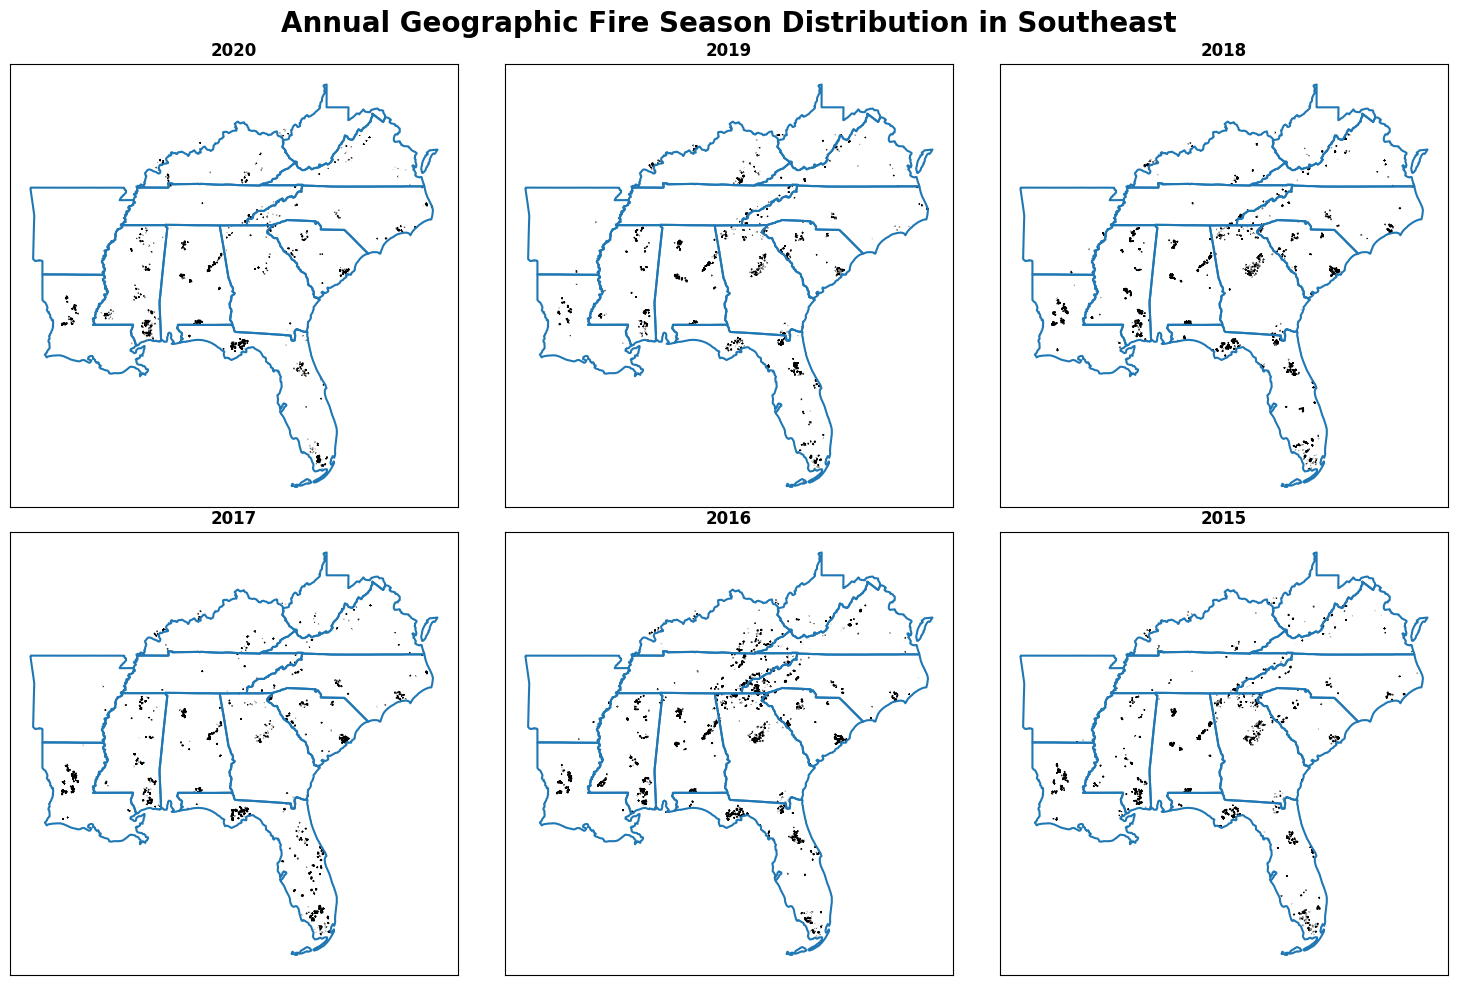

In [14]:
# Get southeast region data and fire polygons
states = gpd.read_file('./southeast/usa-states-census-2014.shp')
southeast = states[states['region'] == 'Southeast']

# Plotting
years = [2015,2016,2017,2018,2019,2020]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for i, ax in enumerate(list(axes.flatten())):
    year = years[-i-1]
    print(year)
    filter = (gdf['year']==year) & (gdf['distance']<650)
    gdf_polygons = gdf.loc[filter, 'geometry']
    gdf_polygons.plot(ax=ax, cmap='Set2', edgecolor='black', aspect=1)
    southeast.boundary.plot(ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{year}', fontweight='bold')
plt.suptitle('Annual Geographic Fire Season Distribution in Southeast', fontweight='bold', fontsize=20)
plt.tight_layout()
plt.savefig('fire_dist.png')

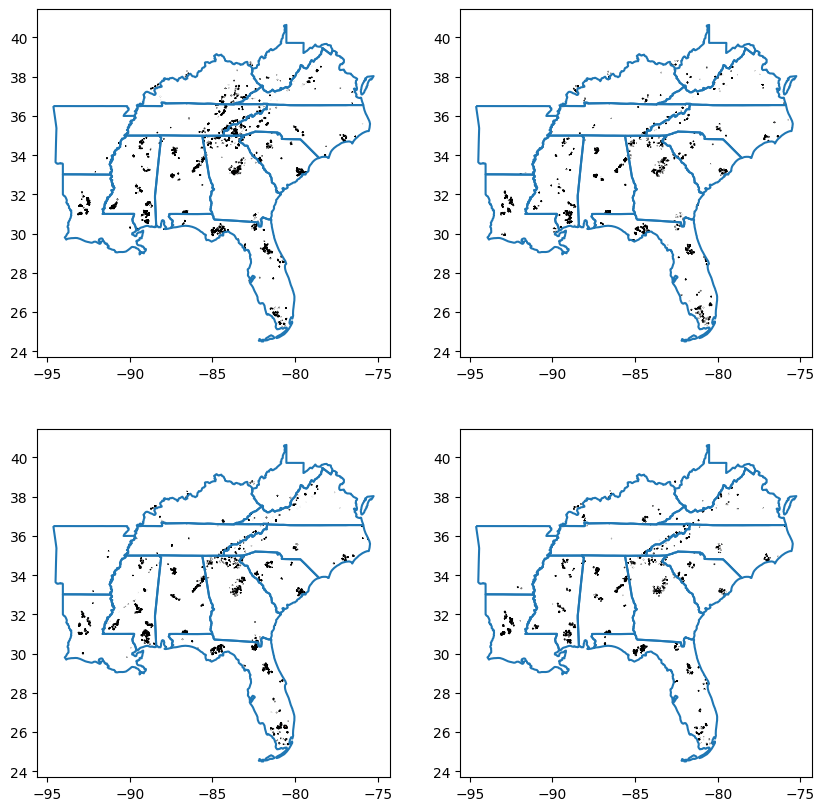

In [16]:
# Get southeast region data and fire polygons
states = gpd.read_file('./southeast/usa-states-census-2014.shp')
southeast = states[states['region'] == 'Southeast']

# Plotting
years = [2013,2014,2015,2016]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, ax in enumerate(list(axes.flatten())):
    year = years[-i-1]
    filter = (gdf['year']==year) & (gdf['distance']<650)
    gdf_polygons = gdf.loc[filter, 'geometry']
    gdf_polygons.plot(ax=ax, cmap='Set2', edgecolor='black', aspect=1)
    southeast.boundary.plot(ax=ax)

In [17]:
# Plotting heart stuff
heart_file = './heart.csv'
heart_df = pd.read_csv(heart_file)


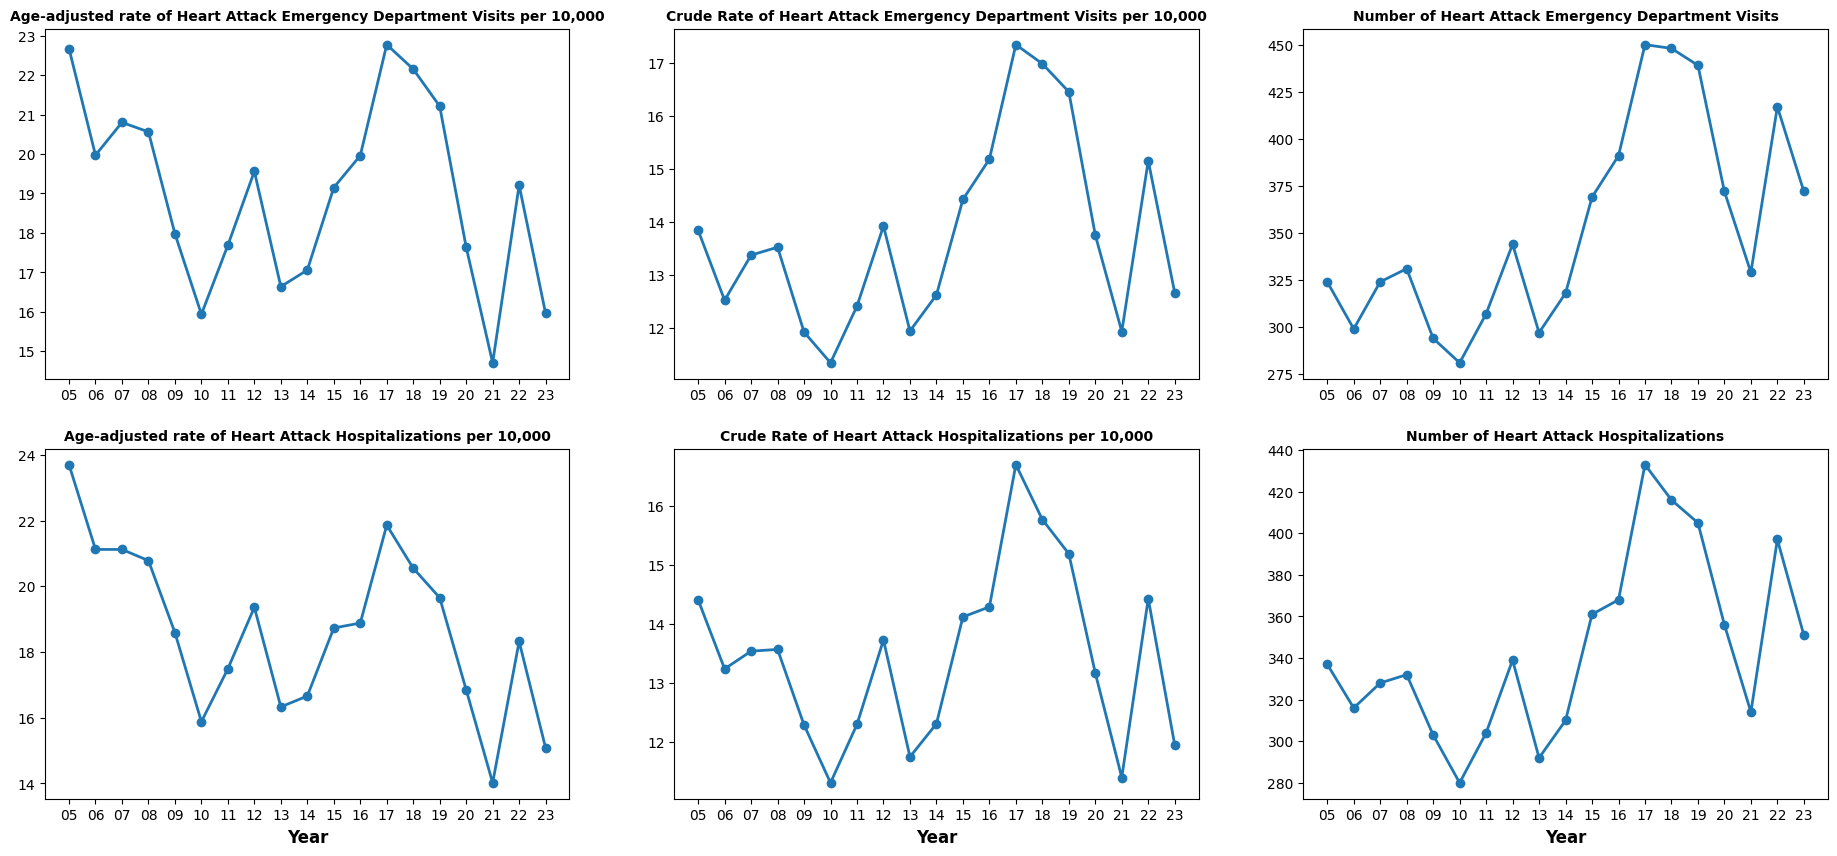

In [19]:
columns = heart_df.columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(23,10))
years = [str(y)[-2:] for y in heart_df['Year']]
for i, ax in enumerate(axes.flatten()):
    ax.plot(years, heart_df[columns[i+1]], marker='o', linewidth=2)
    ax.set_title(columns[i+1], fontweight='bold', fontsize=10)
    if i > 2:
        ax.set_xlabel('Year', fontsize=12, fontweight='bold')
plt.savefig('heart.png')

In [20]:
# Plotting asthma stuff
asthma_file = './asthma.csv'
df = pd.read_csv(asthma_file)

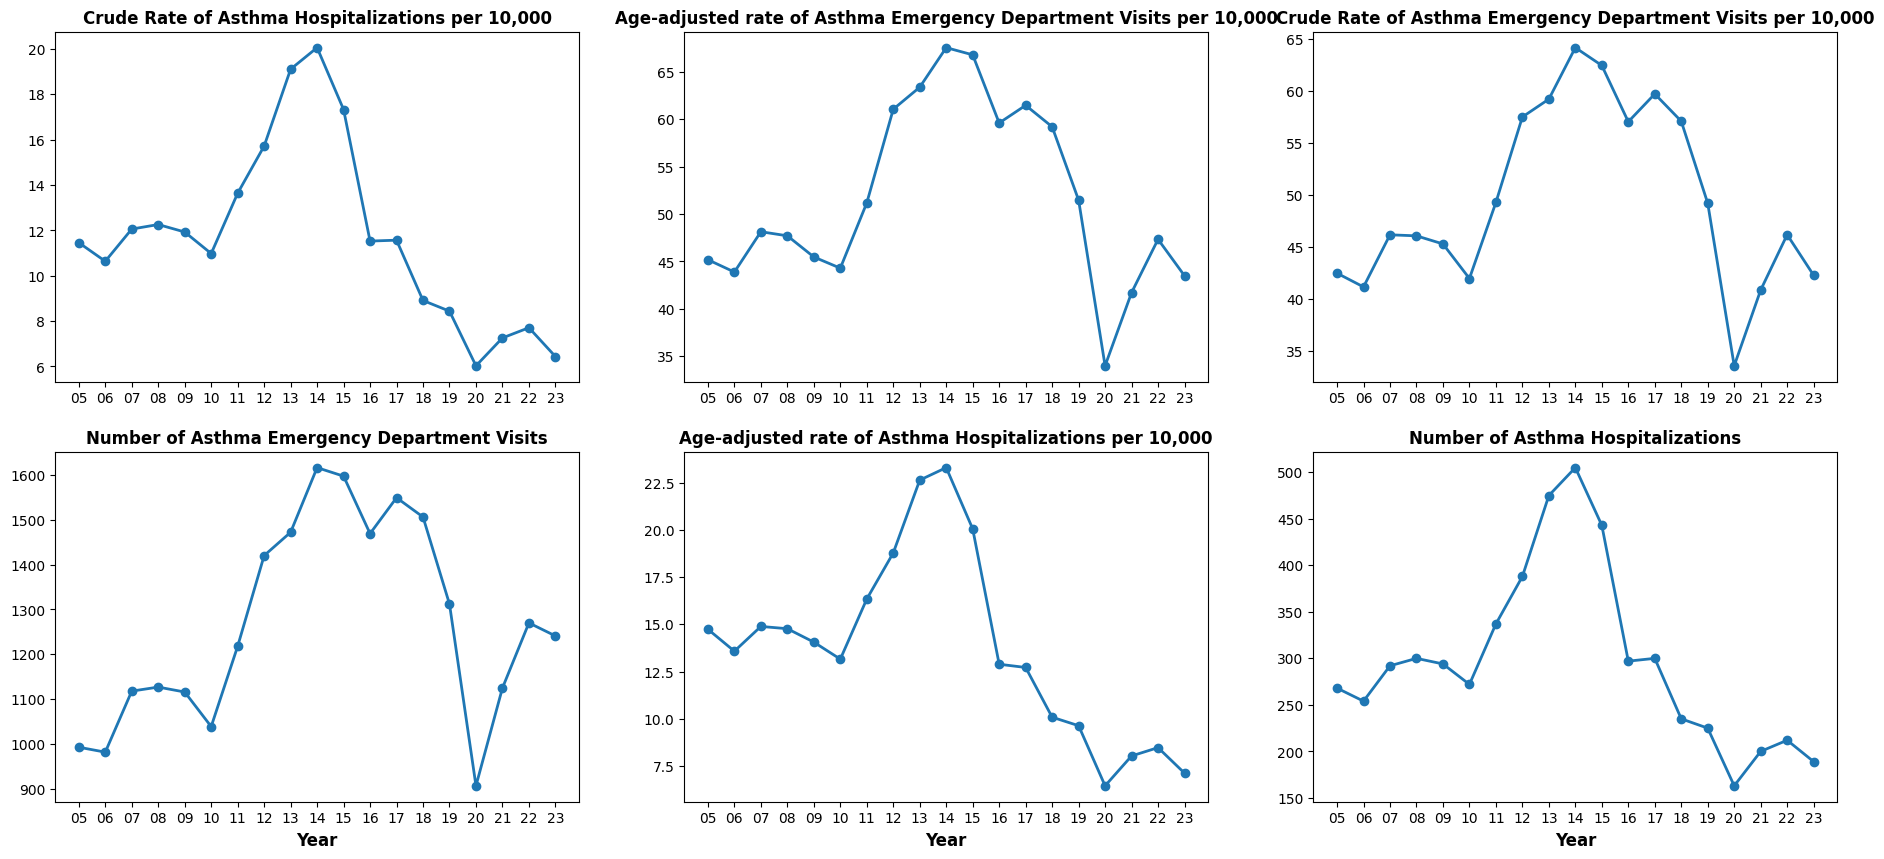

In [21]:
columns = df.columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(23,10))
years = [str(y)[-2:] for y in df['Year']]
for i, ax in enumerate(axes.flatten()):
    ax.plot(years, df[columns[i+1]], marker='o', linewidth=2)
    ax.set_title(columns[i+1], fontweight='bold')
    if i > 2:
        ax.set_xlabel('Year', fontsize=12, fontweight='bold')
plt.savefig('asthma.png')

In [22]:
# AQI
gas_file = './gas_output.csv'
gas = pd.read_csv(gas_file)
years = [int(str(g)[:4]) for g in gas['date_local']]
gas['year'] = years
gas = gas.dropna()

particle_file = './particulate_output.csv'
particle = pd.read_csv(particle_file)
years = [str(p)[:4] for p in particle['date_local']]
particle['year'] = years
particle = particle.dropna()

<Axes: xlabel='year'>

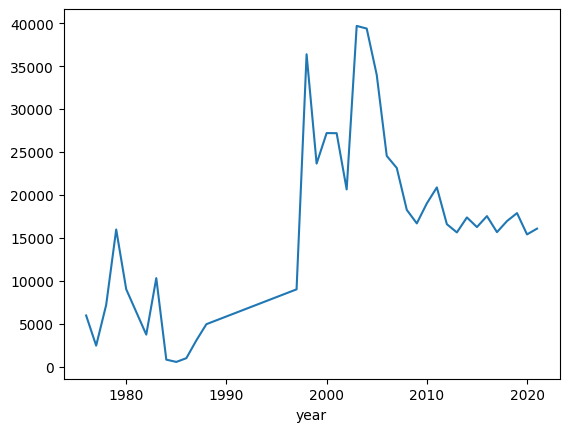

In [24]:
gas_group = gas.groupby('year')['aqi'].sum()
gas_group.plot()

<Axes: xlabel='year'>

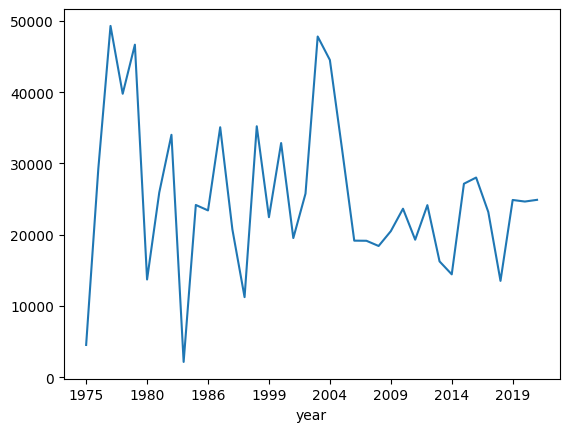

In [25]:
particle_group = particle.groupby('year')['aqi'].sum()
particle_group.plot()

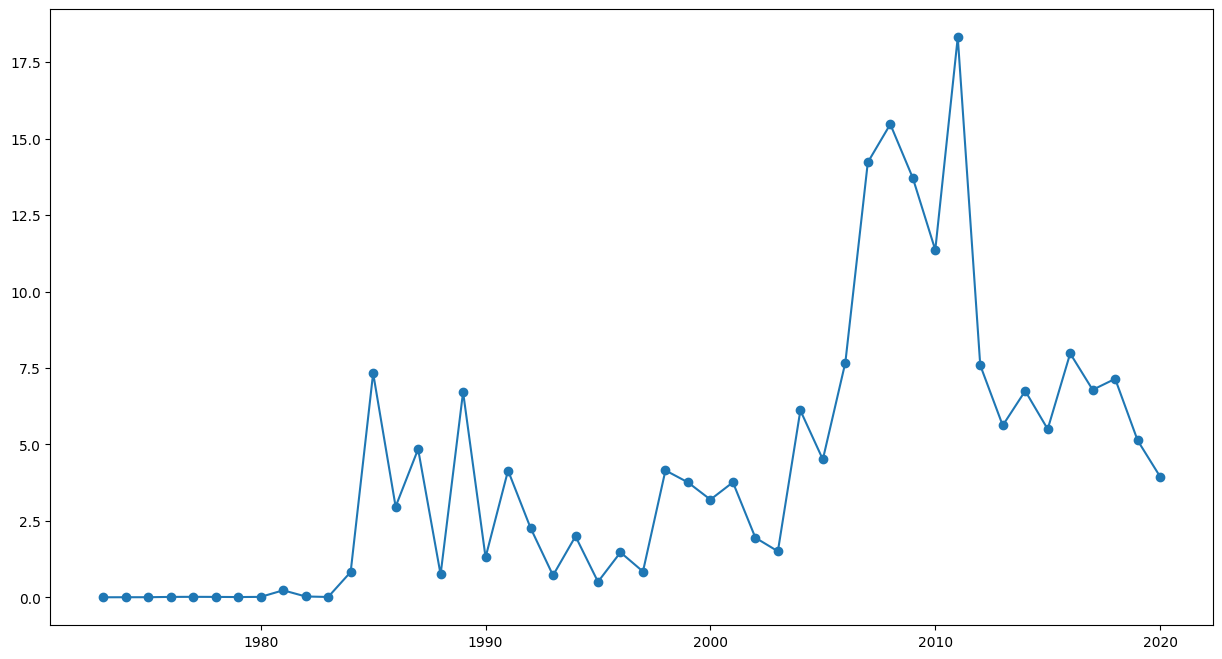

In [123]:
smoke_filter = (gdf['year']>=1973) & (gdf['distance']<650)
smoke = gdf[smoke_filter].dropna()
distance = smoke.groupby('year')['distance'].mean()
acres = smoke.groupby('year')['size'].sum()
smoke_metric = acres/distance**2



fig, ax = plt.subplots(figsize=(15,8))
ax.plot(smoke_metric, marker='o')

In [141]:
full_years = [l for l in range(1976,2022)]
years = [l for l in range(1976, 2022,5)]
combo_years = [1976+i for i in range(len(combo))]
combo_years

[1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012]

In [189]:
print(len(gas_group))
print(len(smoke_metric))

37
48


NameError: name 'smoke_metric' is not defined

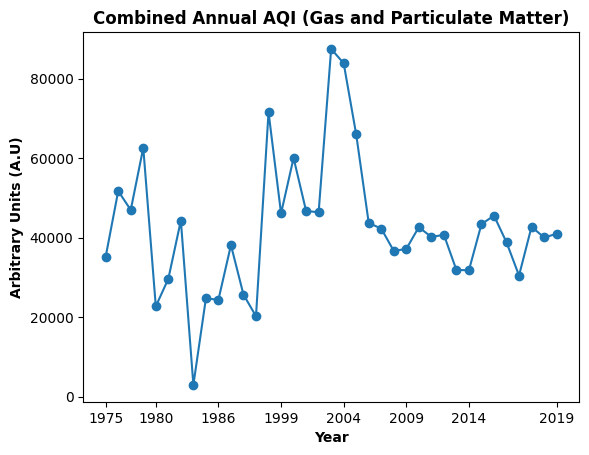

In [26]:
years = [1975, 1980, 1986, 1999, 2004, 2009, 2014, 2019]
ticks = [0, 4, 9, 14, 19, 24, 29, 36]
combo = particle_group.values[1:] + gas_group.values
#combo.plot()
fig,ax = plt.subplots()
ax.plot(combo, marker='o')
#ax = combo.plot(marker='o')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Arbitrary Units (A.U)', fontweight='bold')
ax.set_title('Combined Annual AQI (Gas and Particulate Matter)', fontweight='bold')
# Get the x-tick positions
ax.set_xticks(ticks, years)
ax.plot(smoke_metric)

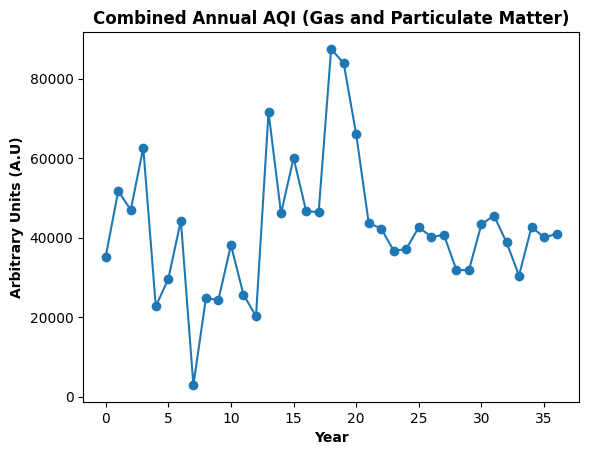

In [28]:
combo = particle_group.values[1:] + gas_group.values
#combo.plot()
fig,ax = plt.subplots()
ax.plot(combo, marker='o')
#ax = combo.plot(marker='o')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Arbitrary Units (A.U)', fontweight='bold')
ax.set_title('Combined Annual AQI (Gas and Particulate Matter)', fontweight='bold')
# Get the x-tick positions
#ax.set_xticks(ticks, years)
plt.savefig('combined_aqi.png')

## Regression Models

Coefficient: -21.181437627078108
Intercept: 26595.445760076545


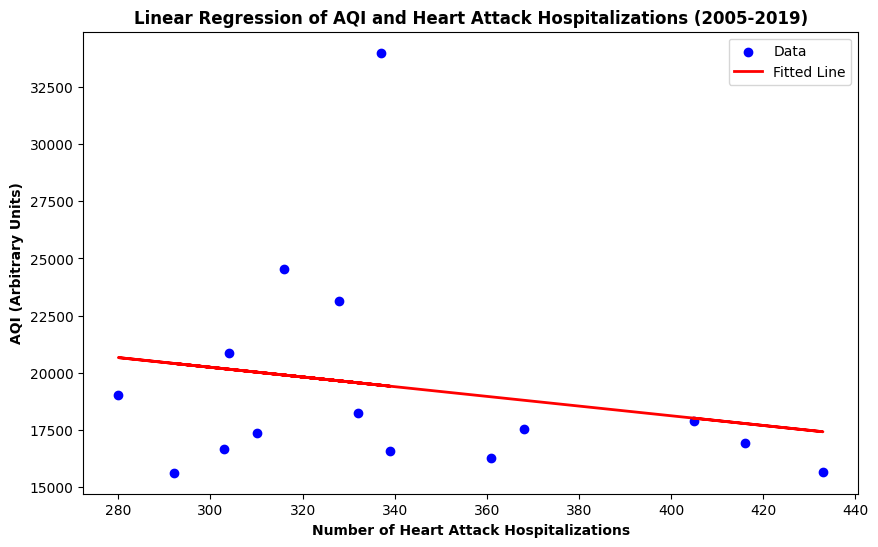

<Figure size 640x480 with 0 Axes>

In [299]:
bad_heart = heart_df['Number of Heart Attack Hospitalizations']
len(bad_heart[:-4])

y= gas[(gas['year'] >= 2005) & (gas['year'] <= 2019)].groupby('year')['aqi'].sum().values.reshape(-1,1)
X = bad_heart.values[:-4].reshape(-1,1)

model = LinearRegression()
model.fit(X, y)


# Print the coefficient and intercept of the linear regression model
print(f"Coefficient: {model.coef_[0][0]}")
print(f"Intercept: {model.intercept_[0]}")

# Predict y values
y_pred = model.predict(X)

# Plot the original data and the linear regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, y_pred, color='red', linewidth=2, label='Fitted Line')
plt.xlabel('Number of Heart Attack Hospitalizations', fontweight='bold')
plt.ylabel('AQI (Arbitrary Units)', fontweight='bold')
plt.title('Linear Regression of AQI and Heart Attack Hospitalizations (2005-2019)', fontweight='bold')
plt.legend()
plt.show()
plt.savefig('regression_heart_attack.png')

In [114]:
hospital = df['Number of Asthma Emergency Department Visits']
len(hospital[:-4])

15

In [304]:
y= gas[(gas['year'] >= 2005) & (gas['year'] <= 2019)].groupby('year')['aqi'].sum().values.reshape(-1,1)
X = hospital.values[:-4].reshape(-1,1)

Coefficient: -14.260640168163231
Intercept: 37931.023002993374


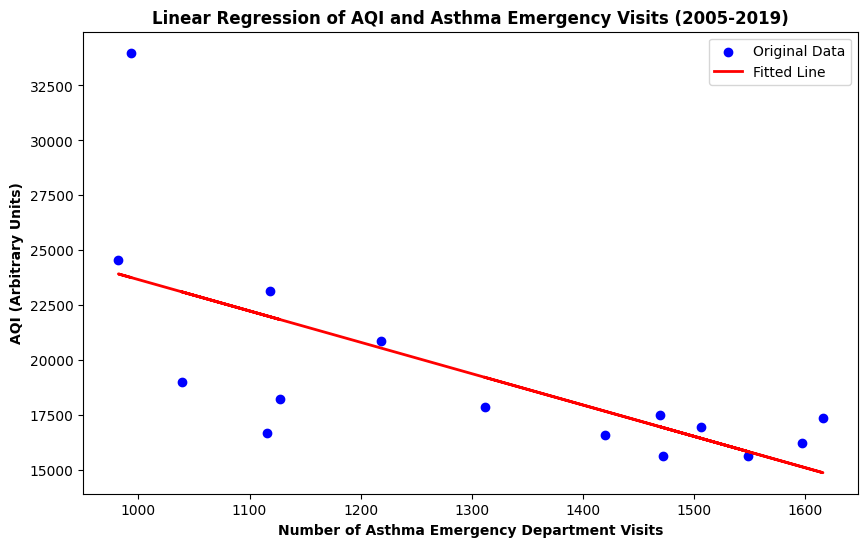

<Figure size 640x480 with 0 Axes>

In [306]:
model = LinearRegression()
model.fit(X, y)


# Print the coefficient and intercept of the linear regression model
print(f"Coefficient: {model.coef_[0][0]}")
print(f"Intercept: {model.intercept_[0]}")

# Predict y values
y_pred = model.predict(X)

# Plot the original data and the linear regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Original Data')
plt.plot(X, y_pred, color='red', linewidth=2, label='Fitted Line')
plt.xlabel('Number of Asthma Emergency Department Visits', fontweight='bold')
plt.ylabel('AQI (Arbitrary Units)', fontweight='bold')
plt.title('Linear Regression of AQI and Asthma Emergency Visits (2005-2019)', fontweight='bold')
plt.legend()
plt.show()
plt.savefig('linear_asthma.png')

In [190]:
y = gas[(gas['year'] >= 2005) & (gas['year'] <= 2019)].groupby('year')['aqi'].sum().values.reshape(-1,1)
X = hospital.values[:-4].reshape(-1,1)

Coefficient: -14.260640168163231
Intercept: 37931.023002993374


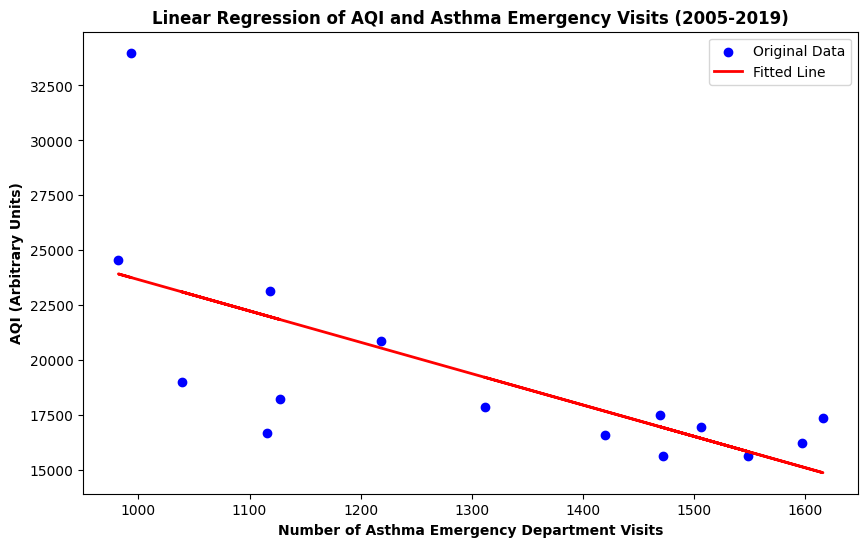

In [191]:
model = LinearRegression()
model.fit(X, y)


# Print the coefficient and intercept of the linear regression model
print(f"Coefficient: {model.coef_[0][0]}")
print(f"Intercept: {model.intercept_[0]}")

# Predict y values
y_pred = model.predict(X)

# Plot the original data and the linear regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Original Data')
plt.plot(X, y_pred, color='red', linewidth=2, label='Fitted Line')
plt.xlabel('Number of Asthma Emergency Department Visits', fontweight='bold')
plt.ylabel('AQI (Arbitrary Units)', fontweight='bold')
plt.title('Linear Regression of AQI and Asthma Emergency Visits (2005-2019)', fontweight='bold')
plt.legend()
plt.show()